In [30]:
from sklearn.model_selection import train_test_split
from mtcnn.mtcnn import MTCNN
from sklearn.preprocessing import Normalizer , LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from keras_facenet import FaceNet
import numpy as np
import wget
import cv2 as cv
import matplotlib.pyplot as plt
import os

In [16]:
IMAGES_PATH = os.path.join("images")
CROPPED_IMAGE_PATH = os.path.join("images" , "cropped_images")

SETTING UP THE LABELS, TRAINING AND TESTING DATA

In [17]:
if os.path.exists(CROPPED_IMAGE_PATH):
    labels = {"_".join(label.split("_")[1:]):i for i , label in enumerate(os.listdir(CROPPED_IMAGE_PATH))}
print(labels)

{'benedict_cumberbatch': 0, 'chris_evans': 1, 'chris_hemsworth': 2, 'mark_ruffalo': 3, 'robert_downey': 4, 'scarlett_johansson': 5, 'tom_hiddleston': 6}


In [18]:
X = []
Y = []
for label , index in labels.items():
    path = os.path.join(CROPPED_IMAGE_PATH , f"cropped_{label}")
    if os.path.exists(path):
        images = os.listdir(path)
        for image in images:
            X.append(cv.imread(os.path.join(path , image)))
            Y.append(index)
X = np.asarray(X)
Y = np.asarray(Y)      
img = cv.imread("deepika(1).pdf")
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , train_size=0.8, shuffle=True)      

C:\Users\parij\AppData\Local\Temp\ipykernel_36488\988532183.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)


FACE EMBEDDINGS AND DATA PREPROCESSING

In [19]:
def get_embedding(model , X):
    samples = np.expand_dims(X , axis=0)
    return model.embeddings(samples)[0]

In [20]:
facenet_model = FaceNet()
new_trainX = []
new_testX = []
for pixels in X_train:
    new_trainX.append(get_embedding(facenet_model , pixels))
for pixels in X_test:
    new_testX.append(get_embedding(facenet_model , pixels))
X_train = np.asarray(new_trainX)
X_test = np.asarray(new_testX)
print("Training Shape: " , str(X_train.shape))
print("Testing Shape: " , str(X_test.shape))

Training Shape:  (104, 512)
Testing Shape:  (26, 512)


In [21]:
in_encoder = Normalizer('l2')
out_encoder = LabelEncoder()
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

TRAINING AND TESTING THE SVC CLASSIFIER

In [22]:
model = SVC(kernel="linear" , probability=True)
model.fit(X_train , Y_train)

SVC(kernel='linear', probability=True)

In [23]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
score_train = accuracy_score(train_pred , Y_train)
score_test = accuracy_score(test_pred , Y_test)
print("training score: " , str(score_train))
print("testing score: " , str(score_test))

training score:  1.0
testing score:  0.9615384615384616


REAL TIME TESTING USING PRETRAINED DATASET(AVENGERS CAST)

In [31]:
def predict_face(img , labels , classifier_model, padding=0 , prob=0.5):
    facenet_model = FaceNet()
    detector = MTCNN()
    result = detector.detect_faces(img)
    predictions = []
    for face in result:
        (x , y , w , h) = face["box"]
        cropped_img = img[y-padding:y+h+padding , x-padding:x+w+padding]
        img = cv.rectangle(img , (x , y) , (x+w , y+h) , (255 , 0 , 0) , 2)
        embedding = facenet_model.embeddings(np.expand_dims(cropped_img , axis=0))
        face_predictions = classifier_model.predict_proba(embedding)
        if np.amax(face_predictions) > prob:
            prediction = np.argmax(face_predictions)
            label = list(labels.keys())[prediction]
            img = cv.putText(img , label , (x+w , y+h) , cv.FONT_HERSHEY_COMPLEX, 1 , (0 , 0 , 255) , 2)
            predictions.append(label)
    return predictions , img    

In [32]:
img_path = "images\\avengers1.jpg"
img = cv.imread(img_path)
detector = MTCNN()
predicitons , img = predict_face(img , labels , model)

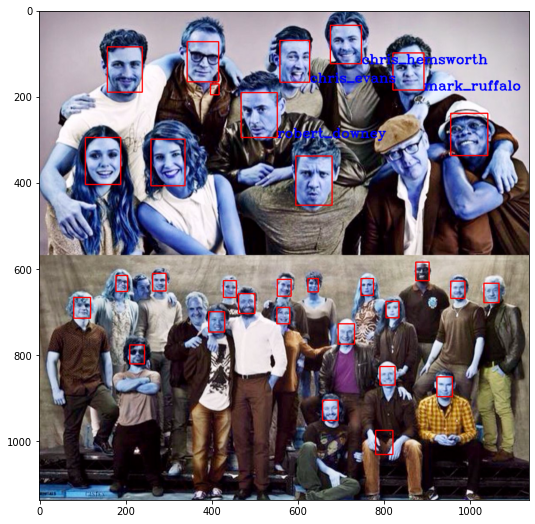

In [33]:
plt.figure(figsize=(16 , 9))
plt.imshow(img)